In [2]:
!mkdir input

In [3]:
!unzip /content/drive/MyDrive/Respiratory_Sound_Database.zip

Archive:  /content/drive/MyDrive/Respiratory_Sound_Database.zip
   creating: Respiratory_Sound_Database/audio_and_txt_files/
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.txt  
  inflating: Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_

In [4]:
!mv "/content/Respiratory_Sound_Database" "/content/input"

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/input/Respiratory_Sound_Database/filename_format.txt
/content/input/Respiratory_Sound_Database/filename_differences.txt
/content/input/Respiratory_Sound_Database/patient_diagnosis.csv
/content/input/Respiratory_Sound_Database/audio_and_txt_files/145_2b2_Al_mc_AKGC417L.txt
/content/input/Respiratory_Sound_Database/audio_and_txt_files/175_1b1_Ll_sc_Litt3200.wav
/content/input/Respiratory_Sound_Database/audio_and_txt_files/193_1b2_Ll_mc_AKGC417L.txt
/content/input/Respiratory_Sound_Database/audio_and_txt_files/114_1b4_Ar_mc_AKGC417L.txt
/content/input/Respiratory_Sound_Database/audio_and_txt_files/177_1b4_Ar_mc_AKGC417L.wav
/content/input/Respiratory_Sound_Database/audio_and_txt_files/226_1b1_Al_sc_Meditron.wav
/content/input/Respiratory_Sound_Database/audio_and_txt_files/177_1b2_Lr_mc_AKGC417L.txt
/content/input/Respiratory_Sound_Database/audio_and_txt_files/163_2b2_Al_mc_AKGC417L.wav
/content/input/Respiratory_Sound_Database/audio_and_txt_files/156_8b3_Lr_mc_AKGC417L.wav
/conte

In [6]:
import librosa
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
!pwd

/content


In [8]:
!mkdir spectrograms

In [9]:
df = pd.read_csv('/content/input/Respiratory_Sound_Database/patient_diagnosis.csv',
                      names=['Patient number', 'Diagnosis']
                  )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


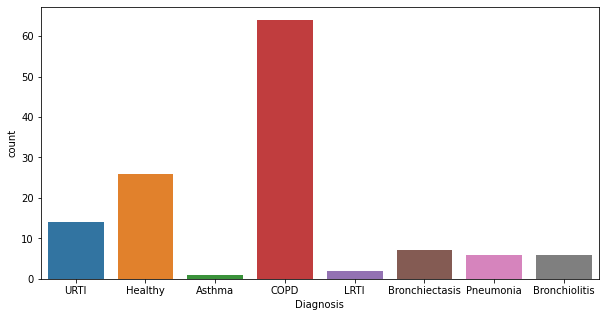

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(df['Diagnosis'])

In [12]:
df_no_diagnosis = pd.read_csv('/content/demographic_info.txt', delimiter=' ',
                              names=['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                             )
df_no_diagnosis.head(5)

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [13]:
df =  df_no_diagnosis.join(df.set_index('Patient number'), on='Patient number', how='left')
df.head(5)

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


In [14]:
df.isna().sum()

Patient number        0
Age                   1
Sex                   1
Adult BMI (kg/m2)    51
Child Weight (kg)    82
Child Height (cm)    84
Diagnosis             0
dtype: int64

In [15]:
base_path = Path('/content/input/Respiratory_Sound_Database/')

In [16]:
df = df[["Patient number", "Sex", "Diagnosis"]]
df.isna().sum()
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [17]:
df.Diagnosis.value_counts()

COPD              63
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [18]:
df = df.loc[df.Diagnosis != "Asthma"]
df = df.loc[df.Diagnosis != "LRTI"]
df = df.reset_index(drop=True)

In [19]:
import soundfile as sf
samplerates = []
targets = []
filenames = []
for file in base_path.glob('audio_and_txt_files/*.wav'):
    _, sr = sf.read(file)
    filenames.append(str(file).split('/')[-1])
    targets.append(int(str(file).split('/')[-1][:3]))
    samplerates.append(sr)

In [20]:
unique, counts = np.unique(samplerates, return_counts=True)
unique, counts

(array([ 4000, 10000, 44100]), array([ 90,   6, 824]))

In [21]:
patient_rate = []
for patient_id in df["Patient number"]:
    srs = True
    for file in base_path.glob(f'audio_and_txt_files/{patient_id}_*.wav'):
        _, sr = sf.read(file)
        if sr < 41000:
            srs = False
    patient_rate.append(srs)

In [22]:
df = df[patient_rate]
df.reset_index(drop=True, inplace=True)


In [23]:
import IPython
def display_wav(patient_id, target):
    patient_sounds = list(base_path.glob(f'audio_and_txt_files/{patient_id}*.wav'))
    test_wav = librosa.core.load(patient_sounds[0], sr=44100)[0]

    fig, ax = plt.subplots(5, 1, figsize=(20,18))
    ax[0].plot(test_wav)
    ax[0].set_title(f"Full {target} waveform")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=512, hop_length=256, win_length=512, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[1].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[1].set_title(f"Slice of {target} mel spectrogram 512 fft")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=1024, hop_length=256, win_length=1024, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[2].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[2].set_title(f"Slice of {target} mel spectrogram 1024 fft")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=2048, hop_length=256, win_length=1024, window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[3].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[3].set_title(f"Slice of {target} mel spectrogram 2048 fft")
    
    chroma = librosa.feature.chroma_stft(test_wav, sr=44100, n_fft=2048, hop_length=256, win_length=1024, window='hann')
    ax[4].imshow(chroma[:,:1000], origin='lower')
    ax[4].set_title(f"Slice of {target} chromagram 2048 fft")

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


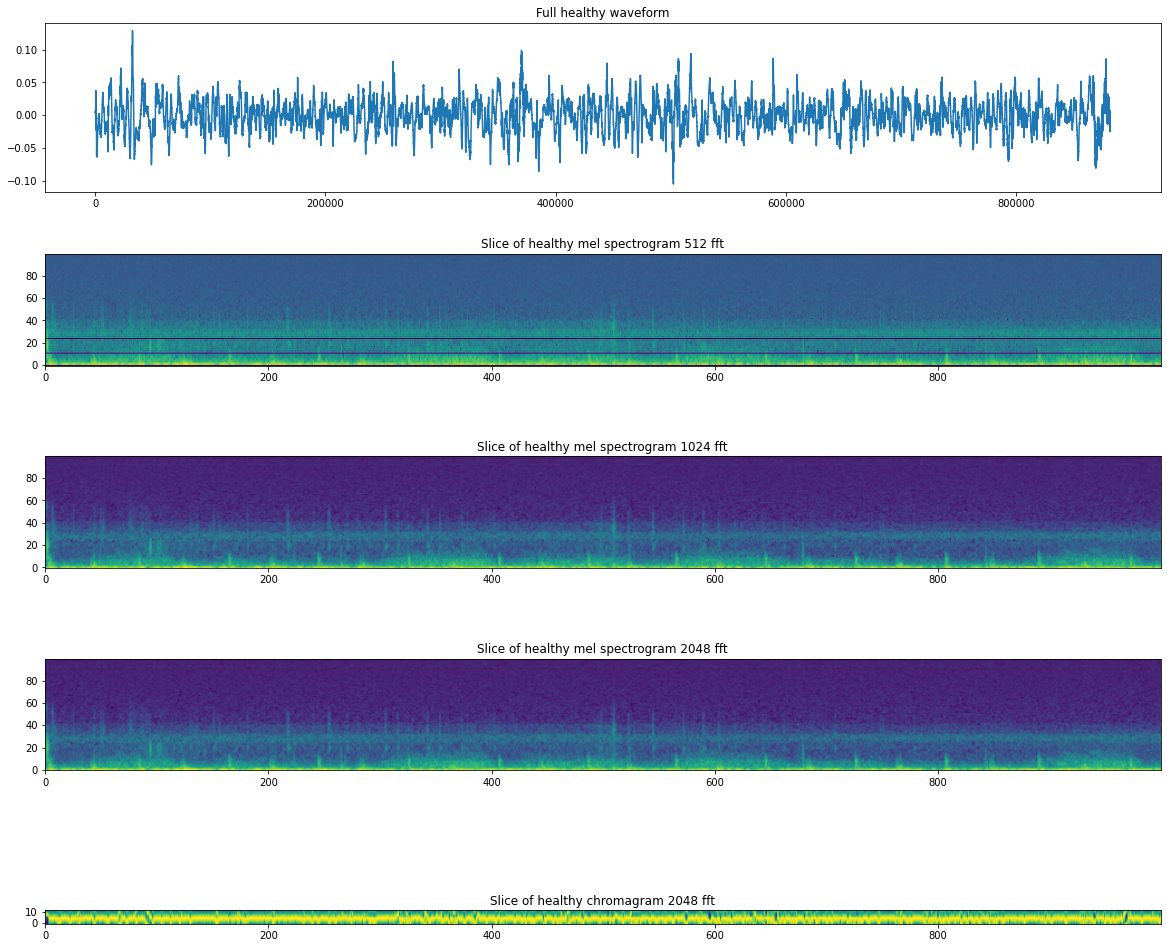

In [24]:
display_wav(102, "healthy")

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


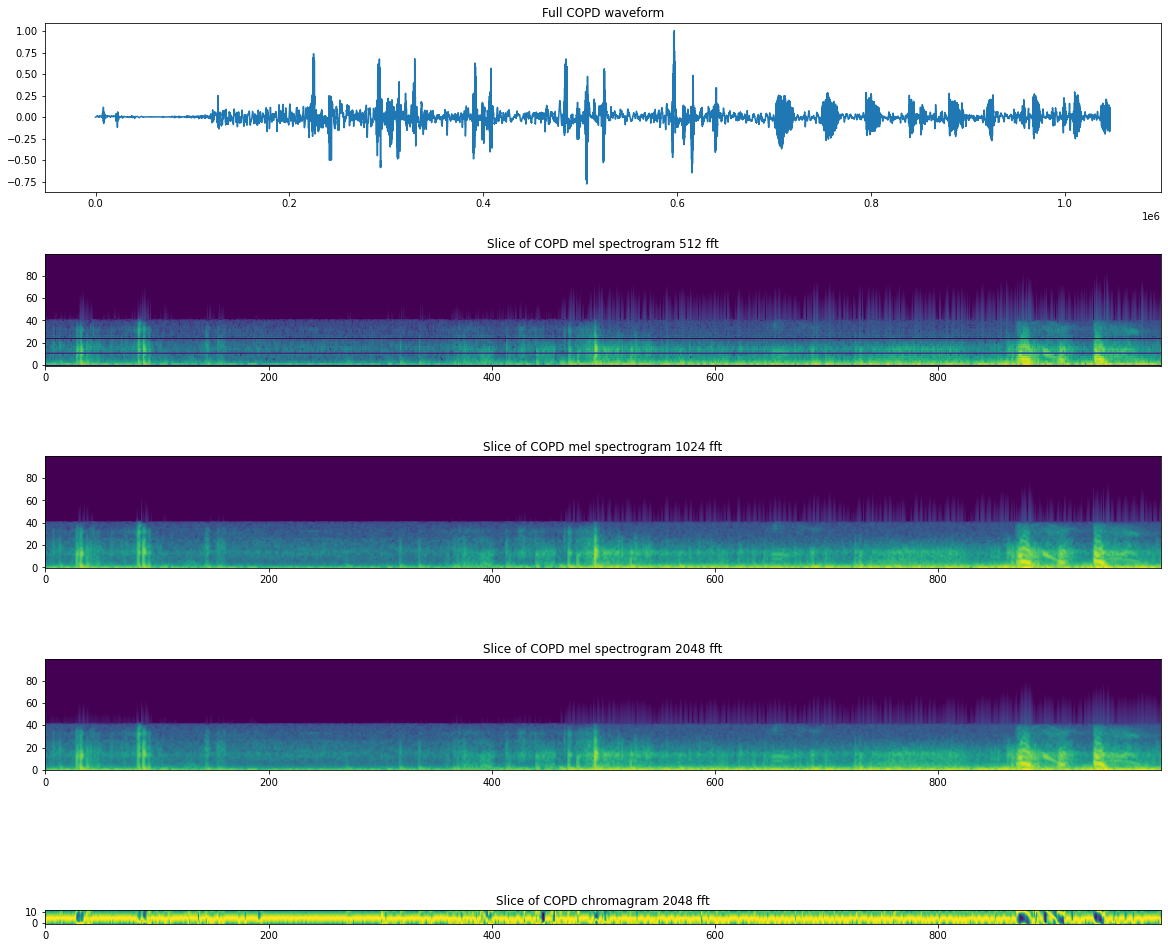

In [25]:
display_wav(104, "COPD")

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


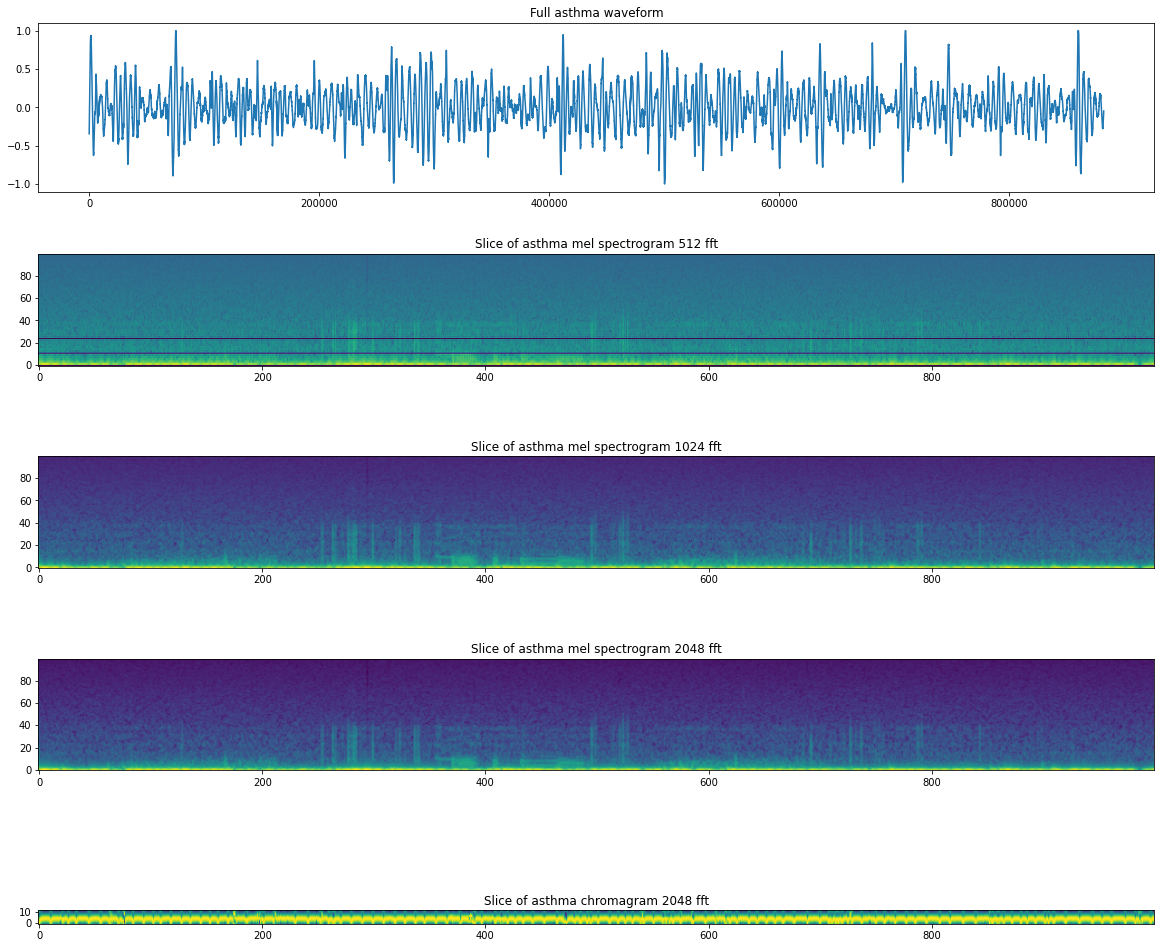

In [26]:
display_wav(103, "asthma")

In [27]:
all_files = np.array(filenames)[np.array(samplerates) > 10000]

mics = []
sound_location = []
for i in range(len(all_files)):
    filename = all_files[i].split('/')[-1].split('_')
    mics.append(filename[4].replace(".wav", ""))
    sound_location.append(filename[2])

In [28]:
all_mics = np.unique(np.array(mics))
all_locations = np.unique(np.array(sound_location))

In [29]:
print(f"Unique microphones: {all_mics}")
print(f"Unique sound positions: {all_locations}")

Unique microphones: ['AKGC417L' 'LittC2SE' 'Meditron']
Unique sound positions: ['Al' 'Ar' 'Ll' 'Lr' 'Pl' 'Pr' 'Tc']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


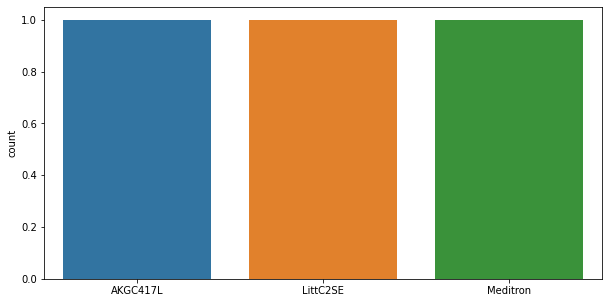

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(all_mics)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


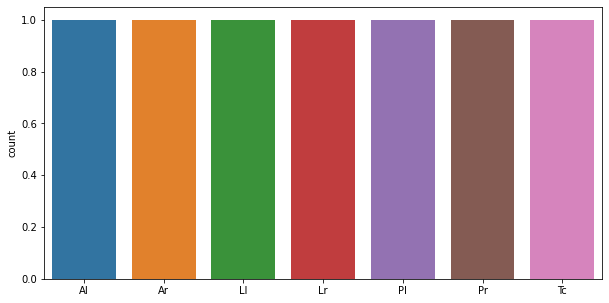

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(all_locations)

In [32]:
from torch.utils.data import Dataset, DataLoader

In [33]:
file_lengths = []
for file in base_path.glob('audio_and_txt_files/*.wav'):
    data, sr = sf.read(file)
    if sr == 44100:
        file_lengths.append(len(data))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


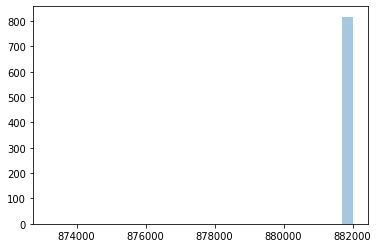

In [34]:
sns.distplot(file_lengths, kde=False)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, 
                                    random_state=42, test_size=0.26, 
                                    stratify=df["Diagnosis"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train target distribution')

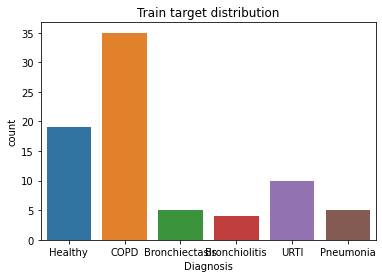

In [36]:
sns.countplot(X_train["Diagnosis"])
plt.title("Train target distribution")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test target distribution')

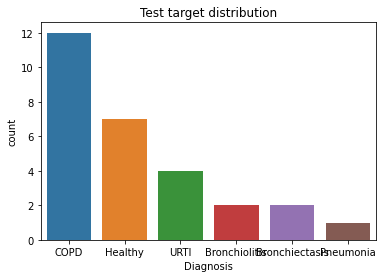

In [37]:
sns.countplot(X_test["Diagnosis"])
plt.title("Test target distribution")

In [38]:
class Collater:
    def __init__(self, sample_seconds, repeat=1):
        self.sample_frames = int(sample_seconds * (44100 // 256))
        self.repeat = repeat
    
    def __call__(self, batch):
        new_batch = {
            "location": [],
            "gender": [],
            "mel": [],
            "chroma": [],
            "mic": [],
            "target": []
        }
        for entry in batch:
            new_batch["location"] += [entry["location"] for i in range(self.repeat)]
            new_batch["gender"]   += [entry["gender"] for i in range(self.repeat)]
            new_batch["mel"]      += [entry["mel"] for i in range(self.repeat)]
            new_batch["chroma"]   += [entry["chroma"] for i in range(self.repeat)]
            new_batch["mic"]      += [entry["mic"] for i in range(self.repeat)]
            new_batch["target"]   += [entry["target"] for i in range(self.repeat)]
        lengths = [entry.shape[1] for entry in new_batch["mel"]]
        
        start_frames = torch.tensor([np.random.randint(0, length - self.sample_frames - 5) for length in lengths])
        
        for i in range(len(new_batch["mel"])):
            new_batch["mel"][i] = new_batch["mel"][i][:, start_frames[i]:start_frames[i]+self.sample_frames]
            new_batch["chroma"][i] = new_batch["chroma"][i][:, start_frames[i]:start_frames[i]+self.sample_frames]
        
        new_batch["mel"] = torch.tensor(new_batch["mel"], dtype=torch.float32)
        new_batch["chroma"] = torch.tensor(new_batch["chroma"], dtype=torch.float32)
        new_batch["location"] = torch.tensor(new_batch["location"], dtype=torch.long)
        new_batch["gender"] = torch.tensor(new_batch["gender"], dtype=torch.long)
        new_batch["mic"] = torch.tensor(new_batch["mic"], dtype=torch.long)
        new_batch["target"] = torch.tensor(new_batch["target"], dtype=torch.long)
        
        return new_batch
            


class SoundDataset(Dataset):
    def __init__(self, df, mics, locations, genders, targets, sound_path, sample_seconds):
        self.all_mics = mics
        self.all_locations = locations
        self.all_genders = genders
        self.all_targets = targets
        self.sample_length = sample_seconds * 44100
        
        data = df.reset_index(drop=True)
        self.mics = []
        self.locations = []
        self.genders = []
        self.targets = []
        self.sound_len = []
        self.sound_files = []
        for i in range(len(df)):
            entry = df.iloc[i]
            patient_id = int(entry["Patient number"])
            for file in sound_path.glob(f"{patient_id}_*.wav"):
                self.sound_files.append(file)
                data, sr = sf.read(file)
                if sr != 44100:
                    print("Skipping ", file.stem)
                    continue
                self.sound_len.append(len(data))
                meta = str(file).split('/')[-1].split('_')
                self.mics.append(self.all_mics.index(meta[4].replace(".wav", "")))
                self.locations.append(self.all_locations.index(meta[2]))
                self.genders.append(self.all_genders.index(entry["Sex"]))
                self.targets.append(self.all_targets.index(entry["Diagnosis"]))
        
    def __getitem__(self, idx):
        sample_length = int(self.sample_length * 2.5)
        start_ind = np.random.randint(0, int(self.sound_len[idx] - sample_length - 5))
        waveform = sf.read(self.sound_files[idx], start=start_ind, frames=sample_length)[0]
        mel = librosa.feature.melspectrogram(waveform, sr=44100, n_fft=2048, hop_length=256, win_length=1024, window='hann', n_mels=100)
        mel[mel < 1e-12] = 1e-12

        chroma = librosa.feature.chroma_stft(waveform, sr=44100, n_fft=2048, hop_length=256, win_length=1024, window='hann')
        
        return {"mel": mel, 
                "chroma": chroma, 
                "gender": self.genders[idx], 
                "location": self.locations[idx], 
                "target": self.targets[idx], 
                "mic": self.mics[idx]}
    
    def __len__(self):
        return len(self.sound_files)

In [39]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, hidden_dim, dropout_prob=0.1, max_len=5000):
        super().__init__()
        self.dropout_prob = dropout_prob

        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return F.dropout(x, p=self.dropout_prob)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=(2,0), stride=1):
        super().__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, kernel_size=5, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels // 2, out_channels // 2, kernel_size=5, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels // 2, out_channels, kernel_size=5, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.triple_conv(x)
    
class Model(nn.Module):
    def __init__(self, mel_channels, output_mel_channels, 
                 chroma_channels, output_chroma_channels, 
                 num_mics, mic_dim, num_sound_srcs, sound_src_dim,
                 num_genders, gender_dim, encoder_dim, 
                 output_dim, num_targets,
                 num_heads=8, num_layers=3, dropout=0.2):
        super().__init__()
        self.spectro_encoder = ConvBlock(mel_channels, output_mel_channels, padding=(0,0), stride=(2,1))
        
        self.chroma_encoder = ConvBlock(chroma_channels, output_chroma_channels, padding=(1,0))
        
        self.microphone_embedding = nn.Embedding(num_mics + 1, mic_dim)
        self.sound_source_embedding = nn.Embedding(num_sound_srcs + 1, sound_src_dim)
        
        self.gender_embedding = nn.Embedding(num_genders + 1, gender_dim)
        
        hidden_dim = 1948
        
        self.linear_projection = nn.Linear(hidden_dim, encoder_dim)
        
        self.pos_encoder = PositionalEncoding(encoder_dim, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=encoder_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.encoder_output_layer = nn.Linear(encoder_dim, output_dim)
        self.output_layer = nn.Linear(output_dim*2, num_targets)
        
    def forward(self, batch):
        
        spectro = self.spectro_encoder(batch["mel"].unsqueeze(1))
        
        chroma = self.chroma_encoder(batch["chroma"].unsqueeze(1))
        n_time = spectro.size(3)
        n_batch = spectro.size(0)
        
        mic_embed = self.microphone_embedding(batch["mic"]).unsqueeze(-1).expand(-1, -1, n_time).transpose(1,2)
        pos_embed = self.sound_source_embedding(batch["location"]).unsqueeze(-1).expand(-1, -1, n_time).transpose(1,2)
        gender_embed = self.gender_embedding(batch["gender"]).unsqueeze(-1).expand(-1, -1, n_time).transpose(1,2)
        
        chroma = chroma.transpose(1,3).reshape(n_batch, n_time, -1)
        spectro = spectro.transpose(1,3).reshape(n_batch, n_time, -1)
        
        x = torch.cat((chroma, spectro, mic_embed, pos_embed, gender_embed), 2)
        x = self.linear_projection(x)
        
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)

        x = self.encoder_output_layer(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = torch.cat([torch.mean(x, dim=1), torch.std(x, dim=1)], dim=1)

        x = self.output_layer(x)

        return x

In [40]:
def to_cuda(batch):
    for key in batch.keys():
        batch[key] = batch[key].cuda()
    return batch

In [41]:
@torch.no_grad()
def validate(model, val_data, criterion, batch_size):
    valset = SoundDataset(val_data, all_mics.tolist(), all_locations.tolist(), ["M", "F"], 
               ["COPD", "Healthy", "URTI", "Bronchiectasis", "Bronchiolitis", "Pneumonia"], base_path / "audio_and_txt_files", 6.0)
    collater = Collater(5.0, repeat=2)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=5, collate_fn=collater)
    
    mean_ce = 0.0
    model.eval()
    for i, batch in enumerate(val_loader):
        batch = to_cuda(batch)
        output = model(batch)
        loss = criterion(output, batch["target"])
        mean_ce += loss.item()
        
    mean_ce /= (i+1)
    model.train()
    return mean_ce

In [42]:
batch_size = 16
criterion = torch.nn.CrossEntropyLoss()
lr = 3e-5
weight_decay=1e-8
epochs = 20
verbose_iter=10

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
model = Model(1, 128, 1, 128, len(all_mics), 8, len(all_locations), 16, 2, 4, 512, 128, 6, num_layers=3).cuda()
train_set = SoundDataset(X_train, all_mics.tolist(), all_locations.tolist(), ["M", "F"], 
               ["COPD", "Healthy", "URTI", "Bronchiectasis", "Bronchiolitis", "Pneumonia"], base_path / "audio_and_txt_files", 6.0)
collater = Collater(5.0, repeat=2)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=5, collate_fn=collater)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
iteration = 0
train_loss = []
val_loss = []
for epoch in range(1,epochs):
    for batch in train_loader:
        batch = to_cuda(batch)
        optimizer.zero_grad()
        
        output = model(batch)
        loss = criterion(output, batch["target"])
        
        loss.backward()
        optimizer.step()
        
        if iteration % verbose_iter == 0:
            print(f"{iteration}: Cross-entropy {loss.item()}")
        train_loss.append(loss.item())
        iteration += 1
    print("VALIDATING")
    val_ce = validate(model, X_test, criterion, batch_size)
    val_loss.append(val_ce)
    
    print(f"DONE EPOCH {epoch}: Train {train_loss[-1]} ;  Val {val_loss[-1]}")

0: Cross-entropy 1.7203620672225952
10: Cross-entropy 0.45804929733276367
20: Cross-entropy 0.21686691045761108
30: Cross-entropy 0.14504967629909515
VALIDATING
DONE EPOCH 1: Train 0.5778026580810547 ;  Val 0.5167682830776487
40: Cross-entropy 0.12422570586204529
50: Cross-entropy 0.7430976629257202
60: Cross-entropy 0.572120726108551
70: Cross-entropy 1.2628618478775024
VALIDATING
DONE EPOCH 2: Train 0.5699478387832642 ;  Val 0.5122162199446133
80: Cross-entropy 0.14546321332454681
90: Cross-entropy 1.2968937158584595
100: Cross-entropy 0.21696138381958008
110: Cross-entropy 0.13847562670707703
VALIDATING
DONE EPOCH 3: Train 0.5342481732368469 ;  Val 0.4817600739853723
120: Cross-entropy 0.5584419965744019
130: Cross-entropy 0.2834956645965576
140: Cross-entropy 0.4194425344467163
150: Cross-entropy 0.1100219190120697
VALIDATING
DONE EPOCH 4: Train 0.44654369354248047 ;  Val 0.4205303969127791
160: Cross-entropy 0.22674648463726044
170: Cross-entropy 0.5260603427886963
180: Cross-entr

Text(0.5, 1.0, 'Train loss')

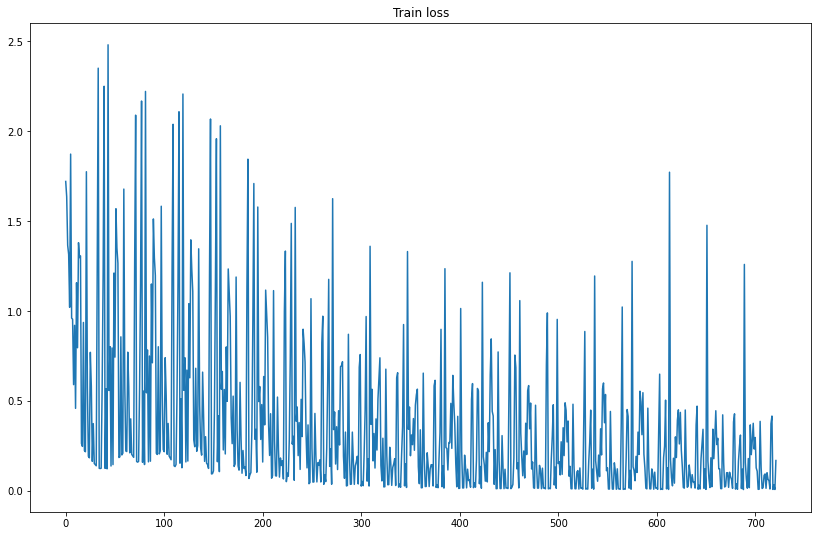

In [45]:
fig, ax = plt.subplots(figsize=(14,9))
plt.plot(train_loss)
plt.title("Train loss")

Text(0.5, 1.0, 'Validation loss')

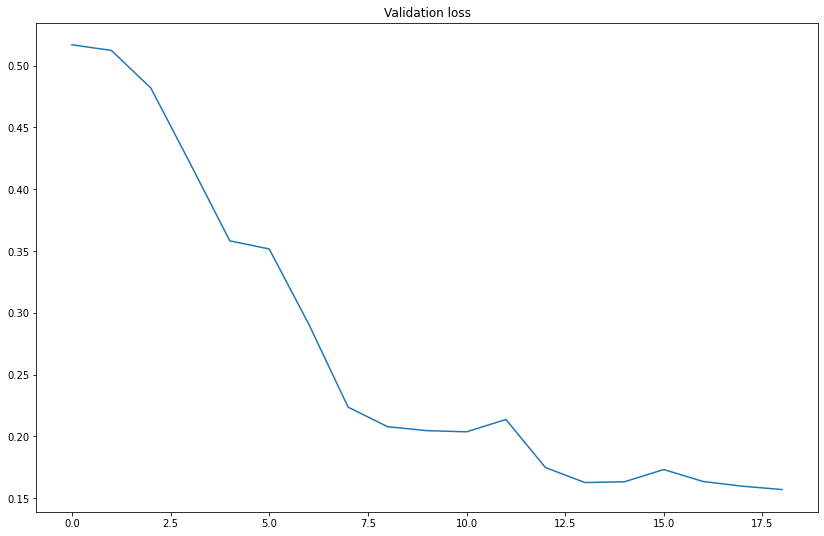

In [46]:
fig, ax = plt.subplots(figsize=(14,9))
plt.plot(val_loss)
plt.title("Validation loss")

In [47]:
valset = SoundDataset(X_test, all_mics.tolist(), all_locations.tolist(), ["M", "F"], 
           ["COPD", "Healthy", "URTI", "Bronchiectasis", "Bronchiolitis", "Pneumonia"], base_path / "audio_and_txt_files", 6.0)
collater = Collater(5.0, repeat=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=5, collate_fn=collater)

targets = []
predictions = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch = to_cuda(batch)
        output = model(batch)
        
        targets.append(batch["target"].cpu().numpy())
        predictions.append(output.cpu().numpy())

In [48]:
new_targets = []
for entry in targets:
    new_targets += entry.tolist()

In [49]:
new_preds = []
for pred in predictions:
    new_preds += np.argmax(pred, axis=1).tolist()

In [50]:
target_classes = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Bronchiolitis", "Pneumonia"]

[Text(0, 0.5, 'COPD'),
 Text(0, 1.5, 'Healthy'),
 Text(0, 2.5, 'URTI'),
 Text(0, 3.5, 'Bronchiectasis'),
 Text(0, 4.5, 'Bronchiolitis'),
 Text(0, 5.5, 'Pneumonia')]

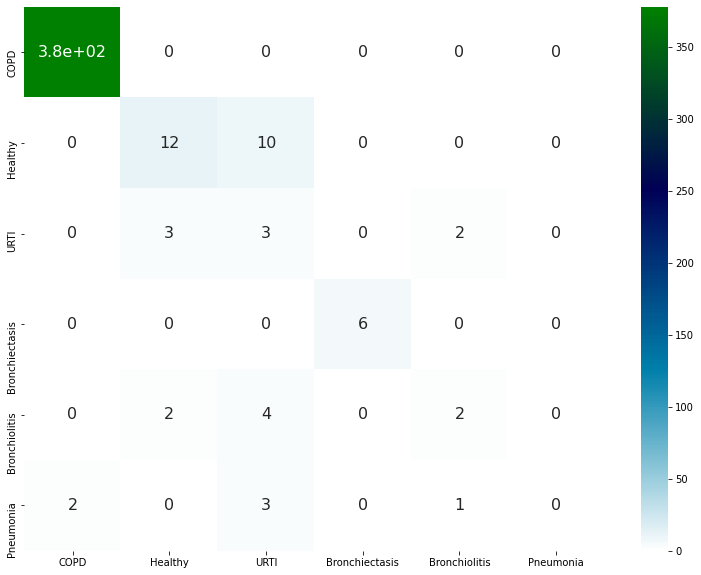

In [51]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(confusion_matrix(new_targets, new_preds), annot=True, annot_kws={"size": 16}, cmap='ocean_r')
ax.set_xticklabels(target_classes)
ax.set_yticklabels(target_classes)

In [52]:
from sklearn.preprocessing import label_binarize
y_test = label_binarize(new_targets, classes=[0, 1, 2, 3, 4, 5])

In [53]:
predicted_proba = []
for proba in predictions:
    predicted_proba += nn.Softmax()(torch.tensor(proba)).cpu().numpy().tolist()
predicted_proba = np.array(predicted_proba)

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

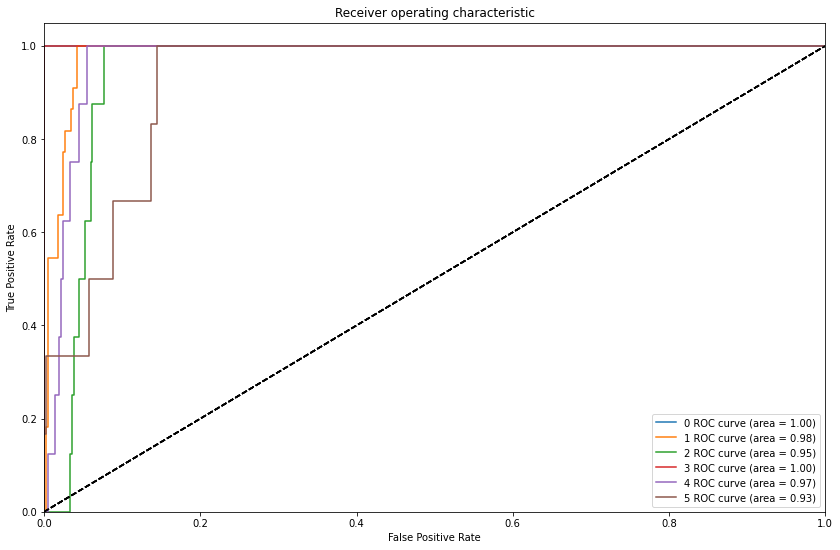

In [55]:
fig, ax = plt.subplots(figsize=(14,9))
for i in range(len(target_classes)):
    plt.plot(fpr[i], tpr[i], label=f'{i} ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")